In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ray
import pickle
import seaborn as sns

### Single Confounding Variable
$$S_i \sim_{i.i.d.} \text{Uniform}[-1,1],$$
$$T_i = \sin(\pi S_i) + E_i \quad \text{ with } \quad E_i \sim_{i.i.d.} \text{Uniform}(-0.3,0.3),$$
$$Y_i = T_i^2 + T_i +1 +10S_i + \epsilon_i \quad \text{ with } \quad \epsilon_i \sim_{i.i.d.} \mathcal{N}(0,1) \quad \text{ for } i=1,...,n.$$

Here, $\theta(t)=2t+1$ and $m(t)=t^2+t+1+\mathbb{E}\left(10S_i \right)=t^2+t+1$.

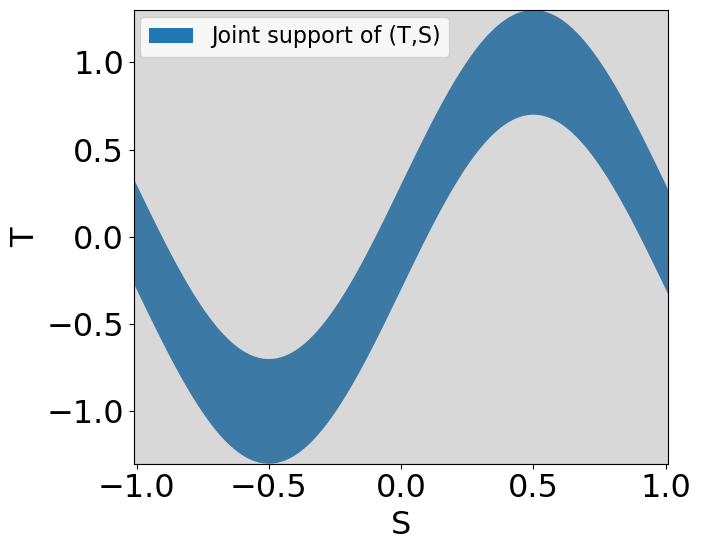

In [2]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(7.5,6))
s_qry = np.linspace(-1.01, 1.01, 200)
plt.fill_between(s_qry, np.sin(np.pi*s_qry)-0.3, np.sin(np.pi*s_qry)+0.3, label='Joint support of (T,S)')
plt.fill_between(s_qry, -1.3, 1.3, color='grey', alpha=0.3)
plt.xlabel('S')
plt.ylabel('T')
plt.legend(fontsize=16, loc='upper left', bbox_to_anchor=(-0.01, 1.01))
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('./Figures/single_conf_TS.pdf', bbox_inches='tight')

In [3]:
n = 2000
np.random.seed(123)
S1 = 2*np.random.rand(n) - 1
E = np.random.rand(n)*0.6 - 0.3
T1 = np.sin(np.pi*S1) + E
Y1 = T1**2 + T1 + 1 + 10*S1 + np.random.normal(loc=0, scale=1, size=n)
X1 = np.concatenate([T1.reshape(-1,1), S1.reshape(-1,1)], axis=1)

t_qry1 = np.linspace(min(T1)+0.01, max(T1)-0.01, 200)

In [4]:
B = 1000
theta_est_boot_arr1 = []
m_est_boot_arr1 = []
Y_RA_boot_arr1 = []
Y_RA_deriv_boot_arr1 = []
for b in range(1, B+1):
    if b == 1:
        with open('./Results_New/Single_Conf_Bootstrap_'+str(b)+'_new.dat', "rb") as file:
        # with open('./Results_New/Single_Conf_Bootstrap_'+str(b)+'_new_n'+str(n)+'.dat', "rb") as file:
            theta_est1, m_est1, Y_RA1, Y_RA_deriv1, theta_est_boot1, m_est_boot1, Y_RA1_boot, Y_RA_deriv1_boot = pickle.load(file)
    else:
        with open('./Results_New/Single_Conf_Bootstrap_'+str(b)+'_new.dat', "rb") as file:
        # with open('./Results_New/Single_Conf_Bootstrap_'+str(b)+'_new_n'+str(n)+'.dat', "rb") as file:
            theta_est_boot1, m_est_boot1, Y_RA1_boot, Y_RA_deriv1_boot = pickle.load(file)
    theta_est_boot_arr1.append(theta_est_boot1)
    m_est_boot_arr1.append(m_est_boot1)
    Y_RA_deriv_boot_arr1.append(Y_RA_deriv1_boot)
    Y_RA_boot_arr1.append(Y_RA1_boot)
theta_est_boot_arr1 = np.array(theta_est_boot_arr1)
m_est_boot_arr1 = np.array(m_est_boot_arr1)
theta_boot_sup1 = np.max(np.abs(theta_est_boot_arr1 - theta_est1), axis=1)
m_boot_sup1 = np.max(np.abs(m_est_boot_arr1 - m_est1), axis=1)

Y_RA_deriv_boot_arr1 = np.array(Y_RA_deriv_boot_arr1)
Y_RA_boot_arr1 = np.array(Y_RA_boot_arr1)
Y_RA_deriv_boot_sup1 = np.max(np.abs(Y_RA_deriv_boot_arr1 - Y_RA_deriv1), axis=1)
Y_RA_boot_sup1 = np.max(np.abs(Y_RA_boot_arr1 - Y_RA1), axis=1)

Y_RA_deriv_alpha1 = np.quantile(Y_RA_deriv_boot_sup1, 0.95)
Y_RA_alpha1 = np.quantile(Y_RA_boot_sup1, 0.95)

theta_alpha1 = np.quantile(theta_boot_sup1, 0.95)
m_alpha1 = np.quantile(m_boot_sup1, 0.95)
print(theta_alpha1)
print(m_alpha1)

1.8663748498587371
0.5569920777915061


In [5]:
theta_boot_abs1 = np.abs(theta_est_boot_arr1 - theta_est1)
m_boot_abs1 = np.abs(m_est_boot_arr1 - m_est1)

theta_alpha_var1 = np.quantile(theta_boot_abs1, 0.95, axis=0)
m_alpha_var1 = np.quantile(m_boot_abs1, 0.95, axis=0)

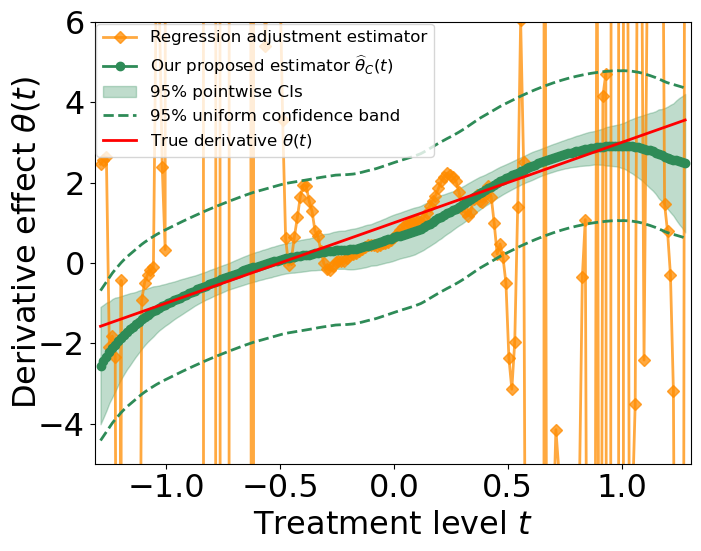

In [16]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(7.5, 6))
plt.plot(t_qry1, Y_RA_deriv1, color='darkorange', marker='D', linewidth=2, alpha=0.75, label=r'Regression adjustment estimator')
plt.plot(t_qry1, theta_est1, color='seagreen', marker='o', linewidth=2, label=r'Our proposed estimator $\widehat{\theta}_C(t)$')
plt.fill_between(t_qry1, theta_est1 - theta_alpha_var1, theta_est1 + theta_alpha_var1, color='seagreen', 
                 alpha=.3, label='95% pointwise CIs')
plt.plot(t_qry1, theta_est1 - theta_alpha1, linestyle='dashed', color='seagreen', linewidth=2)
plt.plot(t_qry1, theta_est1 + theta_alpha1, linestyle='dashed', color='seagreen', linewidth=2,
         label='95% uniform confidence band')
plt.plot(t_qry1, 2*t_qry1+1, color='red', linewidth=2, label=r'True derivative $\theta(t)$')
plt.ylim([-5,6])
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(-0.011, 1.015))
plt.xlabel('Treatment level $t$')
plt.ylabel(r'Derivative effect $\theta(t)$', labelpad=-3)
plt.margins(x=0.01, y=0.012)
plt.tight_layout()
plt.savefig('./Figures/single_conf_theta.pdf', bbox_inches='tight')

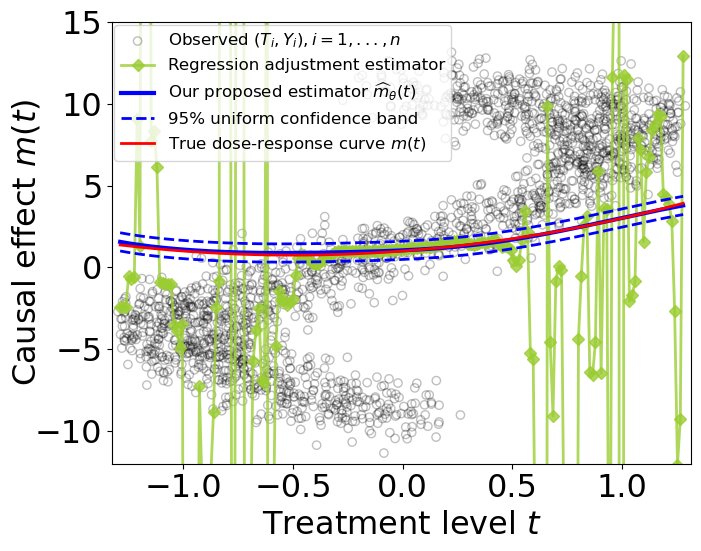

In [9]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(7.5,6))
plt.scatter(T1, Y1, facecolors='none', edgecolors='black', alpha=0.25, 
            label=r'Observed $(T_i,Y_i), i=1,...,n$')
# sns.rugplot(T, height=0.025, color='grey')
plt.plot(t_qry1, Y_RA1, color='yellowgreen', marker="D", linewidth=2, alpha=0.8, label=r'Regression adjustment estimator')
plt.plot(t_qry1, m_est1, color='blue', linewidth=3, label=r'Our proposed estimator $\widehat{m}_{\theta}(t)$')
# plt.fill_between(t_qry1, m_est1 - m_alpha_var1, m_est1 + m_alpha_var1, color='b', 
#                  alpha=.3, label='95% pointwise CIs')
plt.plot(t_qry1, m_est1 - m_alpha1, linestyle='dashed', color='blue', linewidth=2)
plt.plot(t_qry1, m_est1 + m_alpha1, linestyle='dashed', color='blue', linewidth=2,
         label='95% uniform confidence band')
plt.plot(t_qry1, t_qry1**2 + t_qry1+1, color='red', linewidth=2, label=r'True dose-response curve $m(t)$')
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(-0.011, 1.012))
plt.ylim([-12,15])
plt.xlabel('Treatment level $t$')
plt.ylabel(r'Causal effect $m(t)$', labelpad=-5)
plt.margins(x=0.01, y=0.02)
plt.tight_layout()
plt.savefig('./Figures/single_conf_m.pdf', bbox_inches='tight')

### Nonlinear Effect Model
$$\mathbf{S}_i=(S_{i,1},S_{i,2}) \quad \text{ with } \quad S_{i,1},S_{i,2} \sim_{i.i.d.} \text{Uniform}[-1,1],$$
$$Z_i=4S_{i,1} +S_{i,2},$$
$$T_i = \cos(\pi Z_i^3) + Z_i/4 + E_i \quad \text{ with } \quad E_i \sim_{i.i.d.} \text{Uniform}(-0.1,0.1),$$
$$Y_i = T_i^2+T_i+10Z_i + \epsilon_i \quad \text{ with } \quad \epsilon_i \sim_{i.i.d.} \mathcal{N}(0,1) \quad \text{ for } i=1,...,n.$$

Here, $\theta(t)=2t+1$ and $m(t)=t^2+t+\mathbb{E}\left(Z_i \right)=t^2+t$.

In [10]:
n = 2000
np.random.seed(123)
S = np.concatenate([2*np.random.rand(n).reshape(-1,1) - 1, 
                    2*np.random.rand(n).reshape(-1,1) - 1], axis=1)
Z = 4*S[:,0] + S[:,1]
E = 0.2*np.random.rand(n) - 0.1
T = np.cos(np.pi*Z**3) + Z/4 + E
Y = T**2 + T + 10*Z + np.random.normal(loc=0, scale=1, size=n)
X = np.concatenate([T.reshape(-1,1), S], axis=1)

t_qry = np.linspace(min(T)+0.01, max(T)-0.01, 200)

In [11]:
B = 1000
theta_est_boot_arr = []
m_est_boot_arr = []
for b in range(1, B+1):
    if b == 1:
        with open('./Results_New/Nonlinear_Eff_Bootstrap_'+str(b)+'_new1_n'+str(n)+'.dat', "rb") as file:
            theta_est, m_est, Y_RA, Y_RA_deriv, theta_est_boot, m_est_boot, Y_RA_boot, Y_RA_deriv_boot = pickle.load(file)
    else:
        with open('./Results_New/Nonlinear_Eff_Bootstrap_'+str(b)+'_new1_n'+str(n)+'.dat', "rb") as file:
            theta_est_boot, m_est_boot, Y_RA_boot, Y_RA_deriv_boot = pickle.load(file)
    theta_est_boot_arr.append(theta_est_boot)
    m_est_boot_arr.append(m_est_boot)
theta_est_boot_arr = np.array(theta_est_boot_arr)
m_est_boot_arr = np.array(m_est_boot_arr)
theta_boot_sup = np.max(np.abs(theta_est_boot_arr - theta_est), axis=1)
m_boot_sup = np.max(np.abs(m_est_boot_arr - m_est), axis=1)

theta_alpha = np.quantile(theta_boot_sup, 0.95)
m_alpha = np.quantile(m_boot_sup, 0.95)
print(theta_alpha)
print(m_alpha)

5.561837330498932
1.6387913492251065


In [12]:
theta_boot_abs = np.abs(theta_est_boot_arr - theta_est)
m_boot_abs = np.abs(m_est_boot_arr - m_est)

theta_alpha_var = np.quantile(theta_boot_abs, 0.95, axis=0)
m_alpha_var = np.quantile(m_boot_abs, 0.95, axis=0)

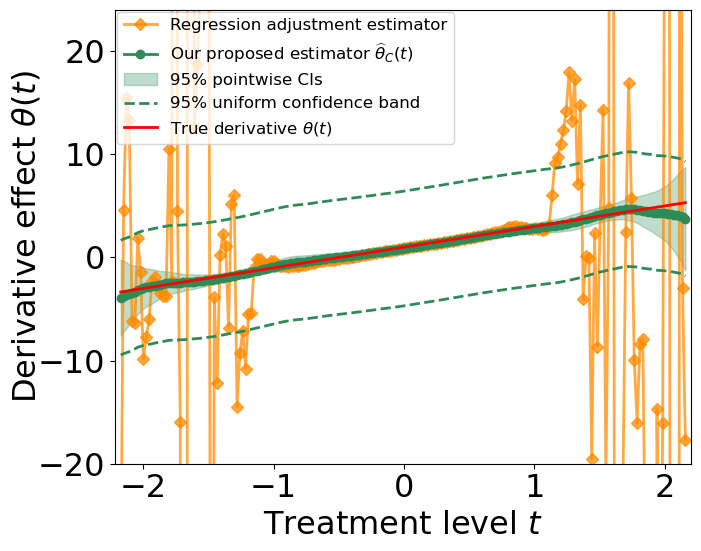

In [19]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(7.5, 6))
plt.plot(t_qry, Y_RA_deriv, color='darkorange', marker='D', linewidth=2, alpha=0.75, 
         label=r'Regression adjustment estimator')
plt.plot(t_qry, theta_est, color='seagreen', marker='o', linewidth=2, label=r'Our proposed estimator $\widehat{\theta}_C(t)$')
plt.fill_between(t_qry, theta_est - theta_alpha_var, theta_est + theta_alpha_var, color='seagreen', 
                 alpha=.3, label='95% pointwise CIs')
plt.plot(t_qry, theta_est - theta_alpha, linestyle='dashed', color='seagreen', linewidth=2)
plt.plot(t_qry, theta_est + theta_alpha, linestyle='dashed', color='seagreen', linewidth=2,
         label='95% uniform confidence band')
plt.plot(t_qry, 2*t_qry+1, color='red', linewidth=2, label=r'True derivative $\theta(t)$')
plt.ylim([-20,24])
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(-0.011, 1.015))
plt.xlabel('Treatment level $t$')
plt.ylabel(r'Derivative effect $\theta(t)$', labelpad=-3)
plt.margins(x=0.01, y=0.012)
plt.tight_layout()
plt.savefig('./Figures/nonlin_conf_theta.pdf', bbox_inches='tight')

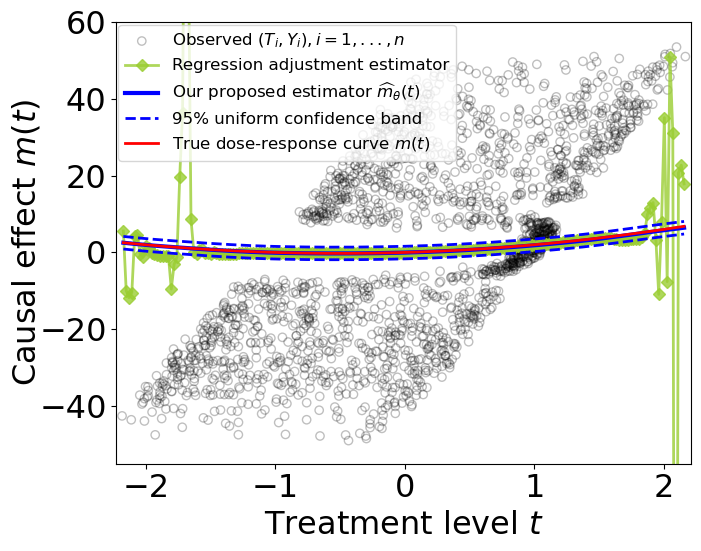

In [33]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(7.5,6))
plt.scatter(T, Y, facecolors='none', edgecolors='black', alpha=0.25, 
            label=r'Observed $(T_i,Y_i), i=1,...,n$')
# sns.rugplot(T, height=0.025, color='grey')
plt.plot(t_qry, Y_RA, color='yellowgreen', marker="D", linewidth=2, alpha=0.8, label=r'Regression adjustment estimator')
plt.plot(t_qry, m_est, color='blue', linewidth=3, label=r'Our proposed estimator $\widehat{m}_{\theta}(t)$')
# plt.fill_between(t_qry1, m_est1 - m_alpha_var1, m_est1 + m_alpha_var1, color='b', 
#                  alpha=.3, label='95% pointwise CIs')
plt.plot(t_qry, m_est - m_alpha, linestyle='dashed', color='blue', linewidth=2)
plt.plot(t_qry, m_est + m_alpha, linestyle='dashed', color='blue', linewidth=2,
         label='95% uniform confidence band')
plt.plot(t_qry, t_qry**2 + t_qry, color='red', linewidth=2, label=r'True dose-response curve $m(t)$')
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(-0.011, 1.012))
plt.ylim([-55, 60])
plt.xlabel('Treatment level $t$')
plt.ylabel(r'Causal effect $m(t)$', labelpad=-2)
plt.margins(x=0.01, y=0.02)
plt.tight_layout()
plt.savefig('./Figures/nonlin_conf_m.pdf', bbox_inches='tight')

### Linear Confounding Model

$$\mathbf{S}_i=(S_{i,1},S_{i,2}) \quad \text{ with } \quad S_{i,1},S_{i,2} \sim_{i.i.d.} \text{Uniform}[-1,1],$$
$$T_i = 2S_{i,1} +S_{i,2} + E_i \quad \text{ with } \quad E_i \sim_{i.i.d.} \text{Uniform}[-0.5,0.5],$$
$$Y_i = T_i+6S_{i,1} +6S_{i,2} + \epsilon_i \quad \text{ with } \quad \epsilon_i \sim_{i.i.d.} \mathcal{N}(0,1) \quad \text{ for } \quad i=1,...,n.$$

Here, $\theta(t)=1$ and $m(t)=t+\mathbb{E}\left(6S_{i,1} +6S_{i,2} \right)=t$.

In [21]:
n = 2000
np.random.seed(123)
S3 = np.concatenate([2*np.random.rand(n).reshape(-1,1) - 1, 
                     2*np.random.rand(n).reshape(-1,1) - 1], axis=1)
E3 = np.random.rand(n) - 0.5
T3 = 2*S3[:,0] + S3[:,1] + E3
Y3 = T3 + 6*S3[:,0] + 6*S3[:,1] + np.random.normal(loc=0, scale=1, size=n)
X3 = np.concatenate([T3.reshape(-1,1), S3], axis=1)

t_qry3 = np.linspace(min(T3), max(T3), 200)

In [22]:
B = 1000
theta_est3_boot_arr = []
m_est3_boot_arr = []
Y_RA_boot_arr3 = []
Y_RA_deriv_boot_arr3 = []
for b in range(1, B+1):
    if b == 1:
        with open('./Results_New/Linear_Conf_Bootstrap_'+str(b)+'_new.dat', "rb") as file:
        # with open('./Results_New/Linear_Conf_Bootstrap_'+str(b)+'_new_n'+str(n)+'.dat', "rb") as file:
            theta_est3, m_est3, Y3_RA, Y3_RA_deriv, theta_est3_boot, m_est3_boot, Y_RA3_boot, Y_RA_deriv3_boot = pickle.load(file)
    else:
        with open('./Results_New/Linear_Conf_Bootstrap_'+str(b)+'_new.dat', "rb") as file:
        # with open('./Results_New/Linear_Conf_Bootstrap_'+str(b)+'_new_n'+str(n)+'.dat', "rb") as file:
            theta_est3_boot, m_est3_boot, Y_RA3_boot, Y_RA_deriv3_boot = pickle.load(file)
    theta_est3_boot_arr.append(theta_est3_boot)
    m_est3_boot_arr.append(m_est3_boot)
    Y_RA_deriv_boot_arr3.append(Y_RA_deriv3_boot)
    Y_RA_boot_arr3.append(Y_RA3_boot)
theta_est3_boot_arr = np.array(theta_est3_boot_arr)
m_est3_boot_arr = np.array(m_est3_boot_arr)
theta_boot3_sup = np.max(np.abs(theta_est3_boot_arr - theta_est3), axis=1)
m_boot3_sup = np.max(np.abs(m_est3_boot_arr - m_est3), axis=1)

theta_alpha3 = np.quantile(theta_boot3_sup, 0.95)
m_alpha3 = np.quantile(m_boot3_sup, 0.95)
print(theta_alpha3)
m_alpha3

1.296538918484394


0.9990431770015201

In [23]:
theta_boot3_abs = np.abs(theta_est3_boot_arr - theta_est3)
m_boot3_abs = np.abs(m_est3_boot_arr - m_est3)

theta_alpha_var3 = np.quantile(theta_boot3_abs, 0.95, axis=0)
m_alpha_var3 = np.quantile(m_boot3_abs, 0.95, axis=0)

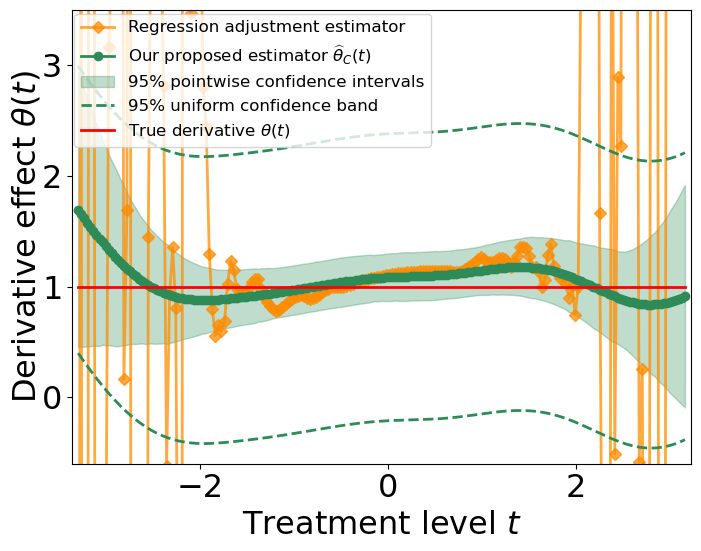

In [30]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(7.5,6))
plt.plot(t_qry3, Y3_RA_deriv, color='darkorange', marker='D', linewidth=2, alpha=0.75, 
         label=r'Regression adjustment estimator')
plt.plot(t_qry3, theta_est3, color='seagreen', marker='o', linewidth=2, label=r'Our proposed estimator $\widehat{\theta}_C(t)$')
plt.fill_between(t_qry3, theta_est3 - theta_alpha_var3, theta_est3 + theta_alpha_var3, color='seagreen', 
                 alpha=.3, label='95% pointwise confidence intervals')
plt.plot(t_qry3, theta_est3 - theta_alpha3, linestyle='dashed', color='seagreen', linewidth=2)
plt.plot(t_qry3, theta_est3 + theta_alpha3, linestyle='dashed', color='seagreen', linewidth=2,
         label='95% uniform confidence band')
plt.plot(t_qry3, np.ones_like(t_qry3), color='red', linewidth=2, label=r'True derivative $\theta(t)$')
plt.ylim([-0.6,3.5])
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(-0.01, 1.01))
plt.xlabel('Treatment level $t$')
plt.ylabel(r'Derivative effect $\theta(t)$', labelpad=0)
plt.margins(x=0.01, y=0.012)
plt.tight_layout()
plt.savefig('./Figures/linear_conf_theta.pdf', bbox_inches='tight')

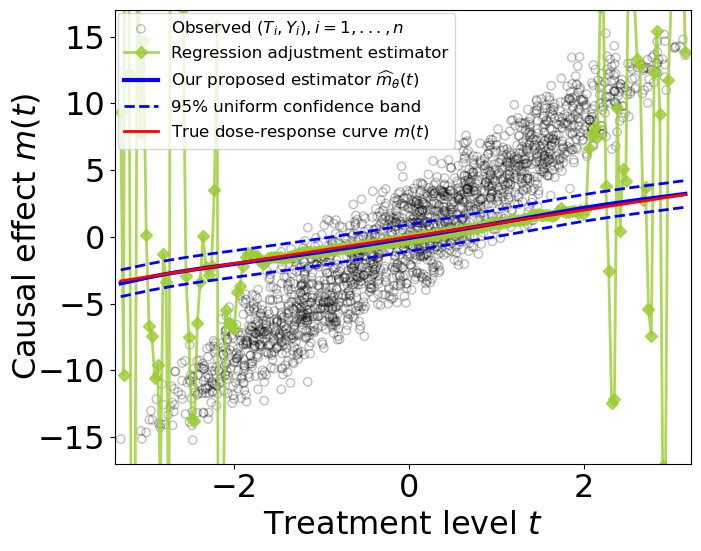

In [32]:
plt.rcParams.update({'font.size': 23})
plt.figure(figsize=(7.5,6))
plt.scatter(T3, Y3, facecolors='none', edgecolors='black', alpha=0.25, 
            label=r'Observed $(T_i,Y_i), i=1,...,n$')
# sns.rugplot(T, height=0.025, color='grey')
plt.plot(t_qry3, Y3_RA, color='yellowgreen', marker="D", linewidth=2, alpha=0.8, 
         label=r'Regression adjustment estimator')
plt.plot(t_qry3, m_est3, color='blue', linewidth=3, label=r'Our proposed estimator $\widehat{m}_{\theta}(t)$')
# plt.fill_between(t_qry3, m_est3 - m_alpha_var3, m_est3 + m_alpha_var3, color='b', 
#                  alpha=.3, label='95% pointwise confidence intervals')
plt.plot(t_qry3, m_est3 - m_alpha3, linestyle='dashed', color='blue', linewidth=2)
plt.plot(t_qry3, m_est3 + m_alpha3, linestyle='dashed', color='blue', linewidth=2,
         label='95% uniform confidence band')
plt.plot(t_qry3, t_qry3, color='red', linewidth=2, label=r'True dose-response curve $m(t)$')
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(-0.01, 1.012))
plt.ylim([-17,17])
plt.xlabel('Treatment level $t$')
plt.ylabel(r'Causal effect $m(t)$', labelpad=-3)
plt.margins(x=0.01, y=0.02)
plt.tight_layout()
plt.savefig('./Figures/linear_conf_m.pdf', bbox_inches='tight')